# Dataset: Churn Modelling

In [1]:
#All imports
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.model_selection import ValidationCurve

#SKLEARN imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.neural_network import MLPClassifier

### Data preparation before running models

In [2]:
#Common functions
def k_folds(k_value,
            model,
            X,
            y):

    kf = model_selection.KFold(n_splits = k_value,random_state = 42)

    result = cross_val_score(model,
                         X,
                         y,
                         cv = kf)

    print("Average accuracy using k folds: {}".format(result.mean()))

def plot_learning_curve(model,
                        X,
                        y,
                        title):

    sizes, training_scores, testing_scores = learning_curve(model,
                                                            X, y,
                                                            cv = 5,
                                                            scoring = 'accuracy',
                                                            train_sizes = np.linspace(0.01, 1.0, 50))


    mean_training = np.mean(training_scores, axis=1)
    mean_testing = np.mean(testing_scores, axis=1)

    plt.plot(sizes, mean_training, '--', color="b",  label="Training score")
    plt.plot(sizes, mean_testing, color="g", label="Cross-validation score")

    plt.title(title)
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

def use_standard_scaler(columns,
                        df):
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

def hyperparameter_curve(model,
                         param_name,
                         param_range,
                         X,
                         y,
                        metric):

    viz = ValidationCurve(model, param_name=param_name,param_range=param_range, cv=5,scoring=metric)

    viz.fit(X, y)
    viz.show()

        
def display_confusion_matrix(confusion_matrix,
                             labels,
                             title):

    ax = sns.heatmap(confusion_matrix/np.sum(confusion_matrix),
                     annot=True,
                     cmap='Blues',
                     fmt='.2%')

    ax.set_title(f'{title}\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()

In [3]:
wine_quality_df = pd.read_csv("winequality-white.csv",delimiter=';')

In [4]:
wine_quality_df['quality_label'] = wine_quality_df['quality'].apply(lambda x: 'low' if x<=5 else 'medium' if x<=7 else 'high')
wine_quality_df = wine_quality_df.drop('quality',1)

C:\Users\Hp\AppData\Local\Temp\ipykernel_13300\2115738919.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  wine_quality_df = wine_quality_df.drop('quality',1)


In [5]:
"""
Split data in train and test set before performing data visualizations
80% training and 20% testing
"""
train_df, test_df = train_test_split(wine_quality_df,
                                     test_size = 0.2,
                                     random_state = 42)

train_df.reset_index(drop = True,
                     inplace = True)
test_df.reset_index(drop = True,
                    inplace = True)
print("Training set: {}".format(train_df.shape))
print("Testing set: {}".format(test_df.shape))

Training set: (3918, 12)
Testing set: (980, 12)


In [6]:
train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()

y_train = train_df['quality_label']
X_train = train_df.drop('quality_label', 1)

y_test = test_df['quality_label']
X_test = test_df.drop('quality_label', 1)

y_train.value_counts()

C:\Users\Hp\AppData\Local\Temp\ipykernel_13300\3729180491.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = train_df.drop('quality_label', 1)
C:\Users\Hp\AppData\Local\Temp\ipykernel_13300\3729180491.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = test_df.drop('quality_label', 1)


medium    2454
low       1319
high       145
Name: quality_label, dtype: int64

#  1. Decision trees with pruning

In [16]:
#******************DEFINING FUNCTIONS*****************

def run_basic_decision_tree(train_input,
                            train_output,
                            test_input,
                            test_output):
    
    clf = DecisionTreeClassifier()
    
    clf = clf.fit(train_input,train_output)
    
    test_predictions = clf.predict(test_input)
    train_predictions = clf.predict(train_input)
    
    print(f'Train score {accuracy_score(train_output,train_predictions)}')
    print(f'Test score {accuracy_score(test_output,test_predictions)}')
    

def select_best_max_depth_decision_tree(train_input,
                                        train_output,
                                        test_input,
                                        test_output,
                                        max_depth_range):
    
    params = {'max_depth': max_depth_range}

    clf = DecisionTreeClassifier()
    gcv = GridSearchCV(estimator = clf,param_grid = params)
    
    gcv.fit(train_input,train_output)

    model = gcv.best_estimator_
    
    model.fit(train_input,train_output)
    
    test_predictions = model.predict(test_input)
    train_predictions = model.predict(train_input)
    
    print(f'Best paramters: {gcv.best_estimator_}')
    
    print(f'Train score {accuracy_score(train_output,train_predictions)}')
    print(f'Test score {accuracy_score(test_output,test_predictions)}')
    
def plot_all_ccp_alphas_values(train_input,
                               train_output,
                               test_input,
                               test_output):

    clf = DecisionTreeClassifier(random_state=42)
    path = clf.cost_complexity_pruning_path(train_input,train_output)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    
    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = DecisionTreeClassifier(random_state = 0,
                                     ccp_alpha = ccp_alpha)
        clf.fit(train_input, train_output)
        clfs.append(clf)

    train_accuracies = []
    test_accuracies = []

    for clf in clfs:

        train_predictions = clf.predict(train_input)
        test_predictions = clf.predict(test_input)

        train_accuracies.append(accuracy_score(train_predictions,train_output))
        test_accuracies.append(accuracy_score(test_predictions,test_output))

    plt.scatter(ccp_alphas,train_accuracies)
    plt.scatter(ccp_alphas,test_accuracies)

    plt.plot(ccp_alphas,
             train_accuracies,
             label = 'Train Accuracy',
             drawstyle = "steps-post")
    plt.plot(ccp_alphas,
             test_accuracies,
             label = 'Test Accuracy',
             drawstyle = "steps-post")

    plt.legend()
    plt.title('Model Accuracy vs Alpha')
    plt.xlabel('Alpha values')
    plt.ylabel('Accuracy')
    plt.show()

def best_model_decision_tree(max_depth,
                             ccp_alpha,
                             train_input,
                             train_output,
                             test_input,
                             test_output):
    
    clf = DecisionTreeClassifier(max_depth = max_depth,
                                 ccp_alpha = ccp_alpha)
    clf = clf.fit(train_input,train_output)

    train_predictions = clf.predict(train_input)
    test_predictions = clf.predict(test_input)

    print(f'Train score using all optimizations: {accuracy_score(train_output,train_predictions)}')
    print(f'Test score using all optimizations: {accuracy_score(test_output,test_predictions)}')
    
    print(classification_report(test_output, test_predictions))
    
    return confusion_matrix(test_output,test_predictions,labels=['high','medium','low'])


In [8]:
print("****Decision tree without any additional parameters****")
run_basic_decision_tree(X_train,y_train, X_test, y_test)

****Decision tree without any additional parameters****
Train score 1.0
Test score 0.7428571428571429


In [11]:
wine_quality_df_dt = wine_quality_df.copy()
y = wine_quality_df_dt['quality_label']
X = wine_quality_df_dt.drop('quality_label', 1)

C:\Users\Hp\AppData\Local\Temp\ipykernel_2640\1734626034.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = wine_quality_df_dt.drop('quality_label', 1)


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


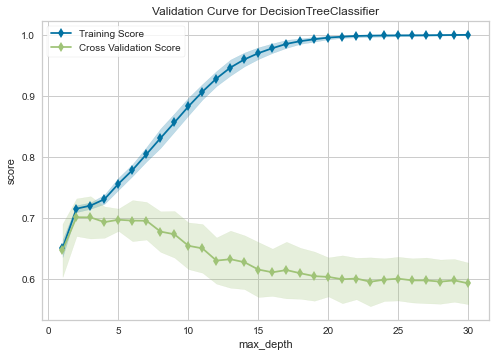

In [12]:
hyperparameter_curve(DecisionTreeClassifier(),'max_depth',[i+1 for i in range(30)],X,y,'accuracy')

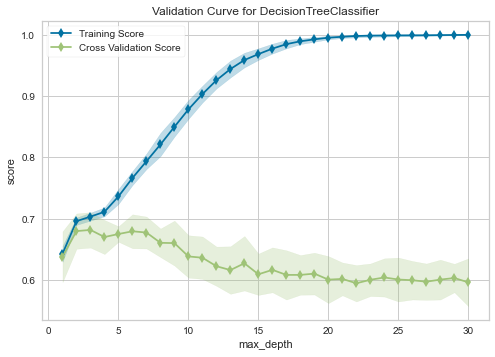

In [14]:
hyperparameter_curve(DecisionTreeClassifier(),'max_depth',[i+1 for i in range(30)],X,y,'f1_weighted')

In [15]:
print("****Decision tree with hyperparameter optimization****")
select_best_max_depth_decision_tree(X_train, y_train, X_test, y_test,[i+1 for i in range(6)])

****Decision tree with hyperparameter optimization****
Best paramters: DecisionTreeClassifier(max_depth=3)
Train score 0.7263910158244002
Test score 0.7030612244897959


****Graph of model performance against all ccp alpha values****


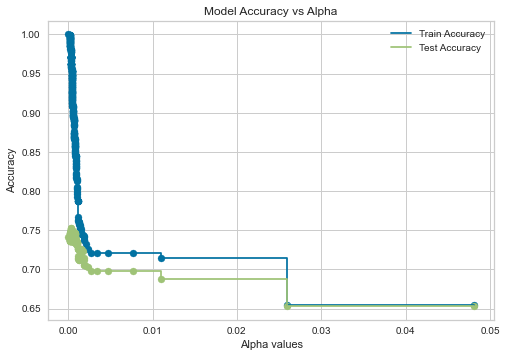

In [17]:
print("****Graph of model performance against all ccp alpha values****")
plot_all_ccp_alphas_values(X_train, y_train, X_test, y_test)

In [18]:
#(max_depth=3,ccp_alpha=0.00001)
genarated_confusion_matrix = best_model_decision_tree(3,0.00001,X_train, y_train, X_test, y_test)

Train score using all optimizations: 0.7263910158244002
Test score using all optimizations: 0.7030612244897959
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        35
         low       0.61      0.56      0.58       321
      medium       0.74      0.82      0.78       624

    accuracy                           0.70       980
   macro avg       0.45      0.46      0.45       980
weighted avg       0.67      0.70      0.69       980



C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


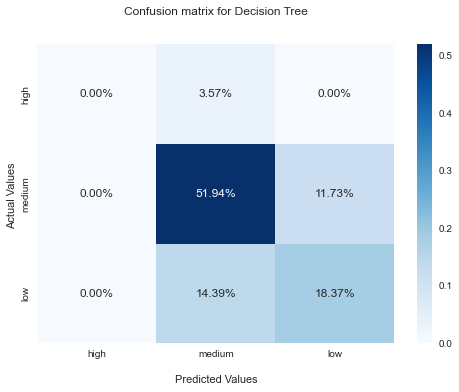

In [19]:
display_confusion_matrix(genarated_confusion_matrix,['high','medium','low'],'Confusion matrix for Decision Tree')

In [20]:
model = DecisionTreeClassifier(max_depth = 3, ccp_alpha = 0.00001)

In [21]:
k_folds(10,model,X,y)

Average accuracy using k folds: 0.7080718667835232


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


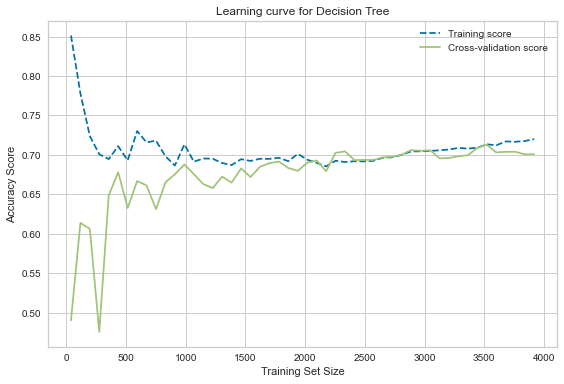

In [22]:
plot_learning_curve(model,X,y,"Learning curve for Decision Tree")

# Support Vector Machines

In [23]:
#******************DEFINING FUNCTIONS*****************

def run_basic_svm(train_input,
                  train_output,
                  test_input,
                  test_output):
    
    svclassifier = SVC()
    svclassifier.fit(train_input, train_output)

    test_predictions = svclassifier.predict(test_input)
    train_prediction = svclassifier.predict(train_input)

    print(f'Initial Train score {accuracy_score(train_output,train_prediction)}')
    print(f'Initial Test score {accuracy_score(test_output,test_predictions)}')

    print(classification_report(test_output, test_predictions))


def find_best_svm_kernel(train_input,
                         train_output,
                         test_input,
                         test_output):
    
    svm_kernels = {}
    
    kernels = ['linear', 'poly', 'rbf','sigmoid']
    
    for i in kernels:

        clf = SVC(kernel = i)
        
        clf.fit(train_input, train_output)
        
        test_predictions = clf.predict(test_input)
        
        svm_kernels[i] = metrics.accuracy_score(test_output, test_predictions)

    svm_kernels = dict(sorted(svm_kernels.items(),
                              key = operator.itemgetter(1),
                              reverse = True))
    print(svm_kernels)

    kernel_type = list(svm_kernels.keys())
    accuracy = list(svm_kernels.values())

    fig = plt.figure(figsize = (5, 3.5))

    plt.bar(kernel_type,accuracy, color ='red',width = 0.4)

    plt.xlabel("SVM Kernel")
    plt.ylabel("Accuracy")
    plt.title("SVM kernels VS Accuracies")
    plt.show()
    
    
def select_best_parameters_svm(train_input,
                               train_output,
                               c_values,
                               gamma_values,
                               kernels):

    param_grid = {'C': c_values,
                  'gamma': gamma_values,
                  'kernel': kernels}

    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)

    grid.fit(train_input, train_output)

    print(grid.best_params_)
    print(grid.best_estimator_)

def best_model_svm(svclassifier,
                   train_input,
                   train_output,
                   test_input,
                   test_output):

    svclassifier.fit(train_input, train_output)

    test_predictions = svclassifier.predict(test_input)
    train_predictions = svclassifier.predict(train_input)

    print(f'Train score {accuracy_score(train_output,train_predictions)}')
    print(f'Test score {accuracy_score(test_output,test_predictions)}')

    print(classification_report(test_output, test_predictions))
    return confusion_matrix(test_output,test_predictions,labels=['high','medium','low'])

In [24]:
train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()

columns = [i for i in train_df_scaled.columns if i!='quality_label']

train_df_scaled = use_standard_scaler(columns, train_df_scaled)
test_df_scaled = use_standard_scaler(columns, test_df_scaled)

y_train_scaled = train_df_scaled['quality_label']
X_train_scaled = train_df_scaled.drop('quality_label', 1)

y_test_scaled = test_df_scaled['quality_label']
X_test_scaled = test_df_scaled.drop('quality_label', 1)

y_train.value_counts()

wine_quality_df_svm = wine_quality_df.copy()
wine_quality_df_svm = use_standard_scaler(columns, wine_quality_df_svm)

y = wine_quality_df_svm['quality_label']
X = wine_quality_df_svm.drop('quality_label', 1)

C:\Users\Hp\AppData\Local\Temp\ipykernel_2640\1079735400.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train_scaled = train_df_scaled.drop('quality_label', 1)
C:\Users\Hp\AppData\Local\Temp\ipykernel_2640\1079735400.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test_scaled = test_df_scaled.drop('quality_label', 1)
C:\Users\Hp\AppData\Local\Temp\ipykernel_2640\1079735400.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = wine_quality_df_svm.drop('quality_label', 1)


In [25]:
run_basic_svm(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

Initial Train score 0.7756508422664625
Initial Test score 0.7408163265306122
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        35
         low       0.69      0.58      0.63       321
      medium       0.76      0.86      0.81       624

    accuracy                           0.74       980
   macro avg       0.48      0.48      0.48       980
weighted avg       0.71      0.74      0.72       980



C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'rbf': 0.7408163265306122, 'linear': 0.713265306122449, 'poly': 0.710204081632653, 'sigmoid': 0.6}


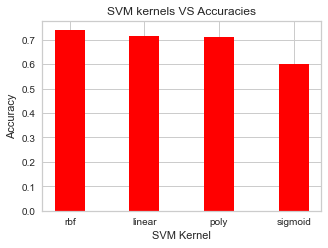

In [26]:
find_best_svm_kernel(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


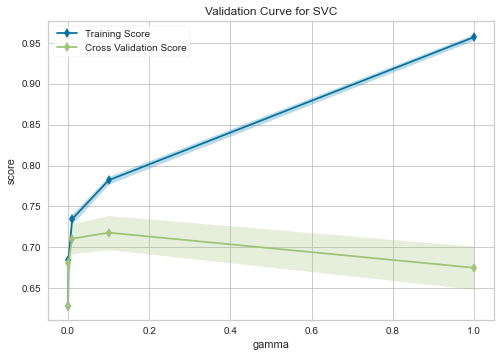

In [27]:
hyperparameter_curve(SVC(),"gamma",[1, 0.1, 0.01, 0.001, 0.0001],X,y,"accuracy")

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


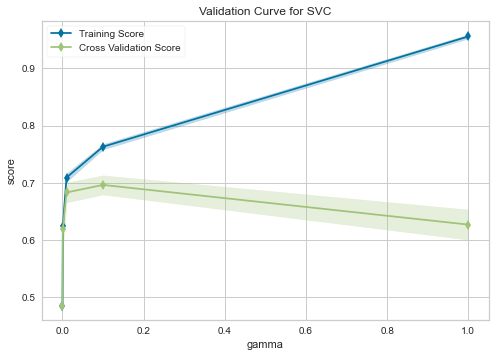

In [28]:
hyperparameter_curve(SVC(),"gamma",[1, 0.1, 0.01, 0.001, 0.0001],X,y,"f1_weighted")

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


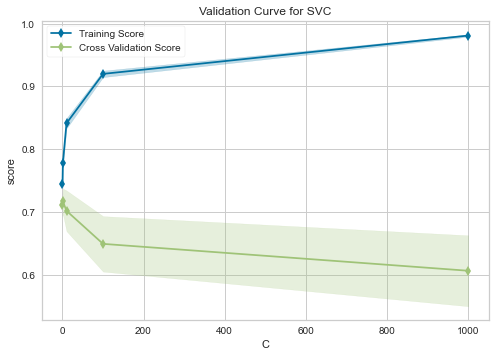

In [29]:
hyperparameter_curve(SVC(),"C",[0.1, 1, 10, 100, 1000],X,y,"accuracy")

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


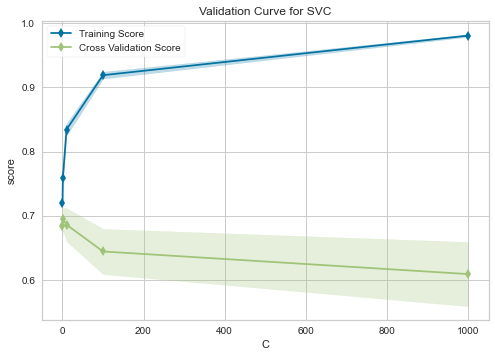

In [30]:
hyperparameter_curve(SVC(),"C",[0.1, 1, 10, 100, 1000],X,y,"f1_weighted")


In [195]:
c_values = [0.1, 1]
gamma_values = [0.1, 0.01, 0.001]
kernels = ['rbf','linear']
select_best_parameters_svm(X_train_scaled, y_train_scaled,c_values,gamma_values,kernels)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   19.0s finished


{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=1, gamma=0.1)


In [31]:
svclassifier_rbf = SVC(kernel='rbf',C=1,gamma=0.1)

In [32]:
svclassifier_linear = SVC(kernel='linear',C=1,gamma=0.1)

In [33]:
print('RBF KERNEL')
genarated_confusion_matrix_rbf = best_model_svm(svclassifier_rbf,X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

RBF KERNEL
Train score 0.777947932618683
Test score 0.7459183673469387
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        35
         low       0.69      0.60      0.64       321
      medium       0.77      0.86      0.81       624

    accuracy                           0.75       980
   macro avg       0.49      0.49      0.49       980
weighted avg       0.72      0.75      0.73       980



C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


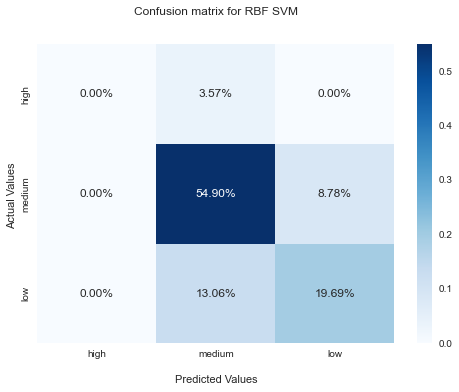

In [34]:
display_confusion_matrix(genarated_confusion_matrix_rbf,['high','medium','low'],'Confusion matrix for RBF SVM')

In [35]:
print('LINEAR KERNEL')
genarated_confusion_matrix_linear = best_model_svm(svclassifier_linear,X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

LINEAR KERNEL
Train score 0.7212863705972435
Test score 0.713265306122449
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        35
         low       0.65      0.51      0.57       321
      medium       0.74      0.86      0.79       624

    accuracy                           0.71       980
   macro avg       0.46      0.46      0.45       980
weighted avg       0.68      0.71      0.69       980



C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


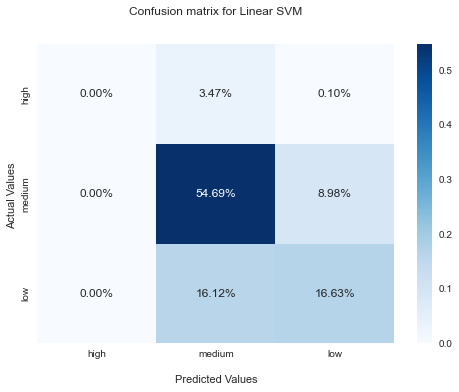

In [36]:
display_confusion_matrix(genarated_confusion_matrix_linear,['high','medium','low'],'Confusion matrix for Linear SVM')

In [37]:
print('LINEAR KERNEL')
k_folds(10,svclassifier_linear,X,y)

LINEAR KERNEL


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Average accuracy using k folds: 0.7125545678394057


In [38]:
print('RBF KERNEL')
k_folds(10,svclassifier_rbf,X,y)

RBF KERNEL


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Average accuracy using k folds: 0.7317499269646508


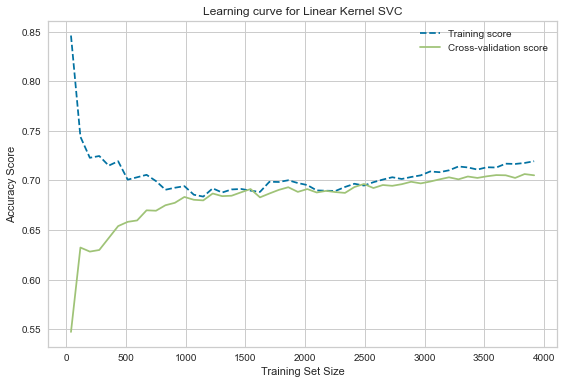

In [39]:
plot_learning_curve(svclassifier_linear,X,y,"Learning curve for Linear Kernel SVC")

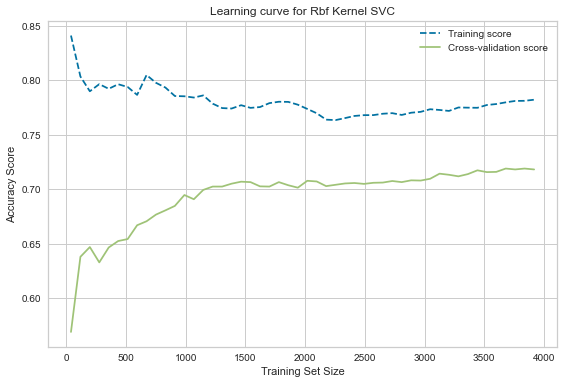

In [40]:
plot_learning_curve(svclassifier_rbf,X,y,"Learning curve for Rbf Kernel SVC")

# k-nearest neighbors

In [7]:
#******************DEFINING FUNCTIONS*****************

def run_basic_knn(train_input,
                  train_output,
                  test_input,
                  test_output):
    
    clf = KNeighborsClassifier()
    clf.fit(train_input, train_output)

    test_predictions = clf.predict(test_input)
    train_prediction = clf.predict(train_input)

    print(f'Initial Train score {accuracy_score(train_output,train_prediction)}')
    print(f'Initial Test score {accuracy_score(test_output,test_predictions)}')

    print(classification_report(test_output, test_predictions))

def find_top_k_values(train_input,
                      train_output,
                      test_input,
                      test_output):
    
    accuracies = {}
    
    for i in range(1,31):

        knn = KNeighborsClassifier(n_neighbors = i)
        knn.fit(train_input, train_output)
        test_predictions = knn.predict(test_input)
        accuracies[i] = metrics.accuracy_score(test_output, test_predictions)


    accuracies = dict(sorted(accuracies.items(), key=operator.itemgetter(1),reverse=True))
    k_values = list(accuracies.keys())[0:8]
    return k_values

def select_best_parameters_knn(train_input,
                               train_output,
                               k_values,
                               p_values):

    n_neighbors = k_values
    p = p_values

    hyperparameters = dict(n_neighbors = n_neighbors,
                           p = p)

    grid = GridSearchCV(KNeighborsClassifier(), hyperparameters, refit = True, verbose = 1)

    grid.fit(train_input, train_output)

    print(grid.best_params_)
    print(grid.best_estimator_)

def best_model_knn(model,
                   train_input,
                   train_output,
                   test_input,
                   test_output):
    
    clf = KNeighborsClassifier(leaf_size = 1, n_neighbors = 13, p = 2)
    
    clf.fit(train_input, train_output)

    test_predictions = clf.predict(test_input)
    train_predictions = clf.predict(train_input)

    print(f'Train score {accuracy_score(train_output,train_predictions)}')
    print(f'Test score {accuracy_score(test_output,test_predictions)}')

    print(classification_report(test_output, test_predictions))
    
    return confusion_matrix(test_output,test_predictions,labels=['high','medium','low'])

In [8]:
train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()

columns = [i for i in train_df_scaled.columns if i!='quality_label']

train_df_scaled = use_standard_scaler(columns, train_df_scaled)
test_df_scaled = use_standard_scaler(columns, test_df_scaled)

y_train_scaled = train_df_scaled['quality_label']
X_train_scaled = train_df_scaled.drop('quality_label', 1)

y_test_scaled = test_df_scaled['quality_label']
X_test_scaled = test_df_scaled.drop('quality_label', 1)

y_train.value_counts()

wine_quality_df_svm = wine_quality_df.copy()
wine_quality_df_svm = use_standard_scaler(columns, wine_quality_df_svm)

y = wine_quality_df_svm['quality_label']
X = wine_quality_df_svm.drop('quality_label', 1)

C:\Users\Hp\AppData\Local\Temp\ipykernel_13300\1079735400.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train_scaled = train_df_scaled.drop('quality_label', 1)
C:\Users\Hp\AppData\Local\Temp\ipykernel_13300\1079735400.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test_scaled = test_df_scaled.drop('quality_label', 1)
C:\Users\Hp\AppData\Local\Temp\ipykernel_13300\1079735400.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = wine_quality_df_svm.drop('quality_label', 1)


In [9]:
run_basic_knn(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

Initial Train score 0.8192955589586524
Initial Test score 0.7122448979591837
              precision    recall  f1-score   support

        high       0.24      0.14      0.18        35
         low       0.63      0.61      0.62       321
      medium       0.76      0.80      0.78       624

    accuracy                           0.71       980
   macro avg       0.55      0.52      0.53       980
weighted avg       0.70      0.71      0.71       980



In [10]:
k_folds(10,KNeighborsClassifier(),X,y)

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Average accuracy using k folds: 0.6770310087225073


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


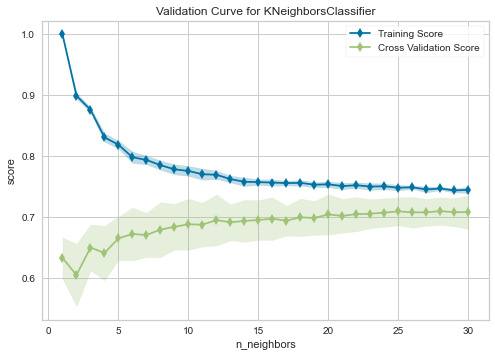

In [45]:
hyperparameter_curve(KNeighborsClassifier(),'n_neighbors',[i+1 for i in range(30)],X,y,"accuracy")

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


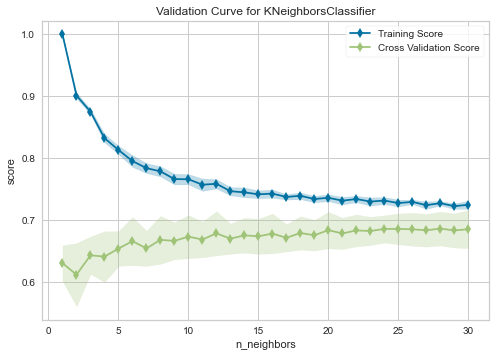

In [46]:
hyperparameter_curve(KNeighborsClassifier(),'n_neighbors',[i+1 for i in range(30)],X,y,"f1_weighted")

In [219]:
n_neighbors = [i+15 for i in range(16)]
p_values= [1,2]
select_best_parameters_knn(X_train_scaled, y_train_scaled,n_neighbors,p_values)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'n_neighbors': 19, 'p': 1}
KNeighborsClassifier(n_neighbors=19, p=1)


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   14.8s finished


In [63]:
model_19 = KNeighborsClassifier(n_neighbors = 19,p=1)

In [64]:
model_25 = KNeighborsClassifier(n_neighbors = 25,p=1)

In [49]:
generated_confusion_matrix_19 = best_model_knn(model_19,X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

Train score 0.759315977539561
Test score 0.726530612244898
              precision    recall  f1-score   support

        high       0.25      0.03      0.05        35
         low       0.66      0.57      0.61       321
      medium       0.75      0.85      0.80       624

    accuracy                           0.73       980
   macro avg       0.56      0.48      0.49       980
weighted avg       0.71      0.73      0.71       980



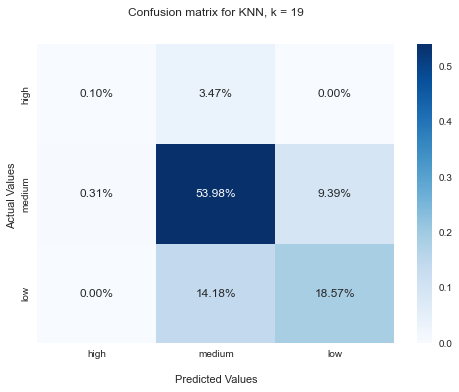

In [50]:
display_confusion_matrix(generated_confusion_matrix_19,['high','medium','low'],'Confusion matrix for KNN, k = 19')

In [65]:
generated_confusion_matrix_25 = best_model_knn(model_25,X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

Train score 0.759315977539561
Test score 0.726530612244898
              precision    recall  f1-score   support

        high       0.25      0.03      0.05        35
         low       0.66      0.57      0.61       321
      medium       0.75      0.85      0.80       624

    accuracy                           0.73       980
   macro avg       0.56      0.48      0.49       980
weighted avg       0.71      0.73      0.71       980



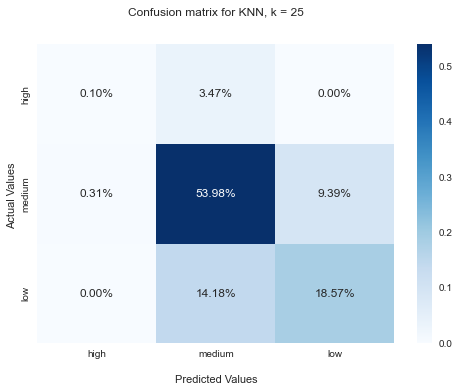

In [66]:
display_confusion_matrix(generated_confusion_matrix_25,['high','medium','low'],'Confusion matrix for KNN, k = 25')

In [67]:
print('K = 19: ')
k_folds(10,model_19,X,y)

print('K = 25: ')
k_folds(10,model_25,X,y)

K = 19: 


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Average accuracy using k folds: 0.7190868494637118
K = 25: 


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Average accuracy using k folds: 0.7241888902800383


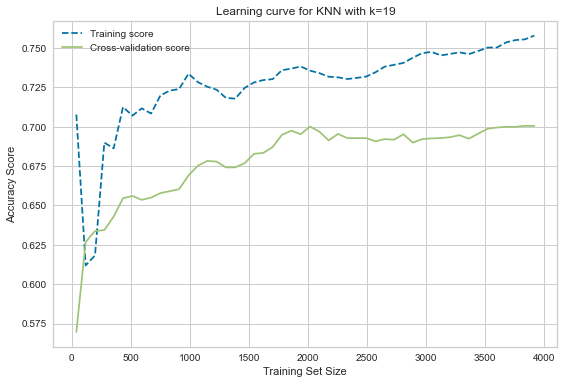

In [60]:
plot_learning_curve(model_19,X,y,"Learning curve for KNN with k=19")

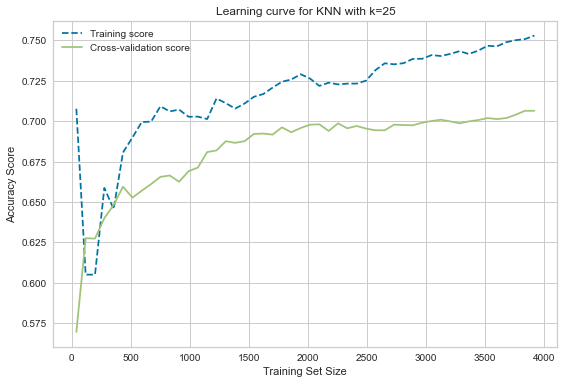

In [72]:
plot_learning_curve(model_25,X,y,"Learning curve for KNN with k=25")

# Boosting

In [73]:
#******************DEFINING FUNCTIONS*****************


def run_basic_boosting(train_input,
                      train_output,
                      test_input,
                      test_output):

    
    gbc = GradientBoostingClassifier()

    model = gbc.fit(train_input, train_output)
    
    test_predictions = model.predict(test_input)
    train_prediction = model.predict(train_input)

    print(f'Initial Train score {accuracy_score(train_output,train_prediction)}')
    print(f'Initial Test score {accuracy_score(test_output,test_predictions)}')

    print(classification_report(test_output, test_predictions))

def find_top_estimators_values(train_input,
                               train_output,
                               test_input,
                               test_output):
    
    n_estimators = {}
    for i in range(1,100):

        gbc = GradientBoostingClassifier(n_estimators = i)
        
        gbc.fit(train_input, train_output)
        
        test_predictions = gbc.predict(test_input)
        n_estimators[i] = metrics.accuracy_score(test_output, test_predictions)


    n_estimators = dict(sorted(n_estimators.items(), key=operator.itemgetter(1),reverse=True))
    print(n_estimators)
    n_estimators = list(n_estimators.keys())[0:8]
    return n_estimators

def select_best_parameters_gbc(train_input,
                               train_output,
                               max_depth_range,
                               n_estimators_range):


    param_grid = {'max_depth': max_depth_range,
                  'n_estimators': n_estimators_range}

    boost = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid=param_grid, cv=10)
    boost.fit(train_input, train_output)
    print("Per Hyperparameter tuning, best parameters are:")
    print(boost.best_params_)

    
def best_model_gbc(model,
                   train_input,
                   train_output,
                   test_input,
                   test_output):
    
    model.fit(train_input, train_output)

    test_predictions = model.predict(test_input)
    train_predictions = model.predict(train_input)

    print(f'Train score {accuracy_score(train_output,train_predictions)}')
    print(f'Test score {accuracy_score(test_output,test_predictions)}')
    
    print(classification_report(test_output, test_predictions))
    
    return confusion_matrix(test_output, test_predictions,labels=['high','medium','low'])



In [74]:
y_train = train_df['quality_label']
X_train = train_df.drop('quality_label', 1)

y_test = test_df['quality_label']
X_test = test_df.drop('quality_label', 1)

y_train.value_counts()

C:\Users\Hp\AppData\Local\Temp\ipykernel_2640\2921404945.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = train_df.drop('quality_label', 1)
C:\Users\Hp\AppData\Local\Temp\ipykernel_2640\2921404945.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = test_df.drop('quality_label', 1)


medium    2454
low       1319
high       145
Name: quality_label, dtype: int64

In [75]:
run_basic_boosting(X_train,y_train,X_test,y_test)

Initial Train score 0.8095967330270546
Initial Test score 0.7520408163265306
              precision    recall  f1-score   support

        high       0.67      0.17      0.27        35
         low       0.69      0.61      0.65       321
      medium       0.78      0.86      0.82       624

    accuracy                           0.75       980
   macro avg       0.71      0.55      0.58       980
weighted avg       0.75      0.75      0.74       980



In [76]:
wine_quality_df_b = wine_quality_df.copy()

y = wine_quality_df_b['quality_label']
X = wine_quality_df_b.drop('quality_label', 1)

C:\Users\Hp\AppData\Local\Temp\ipykernel_2640\2633458535.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = wine_quality_df_b.drop('quality_label', 1)


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


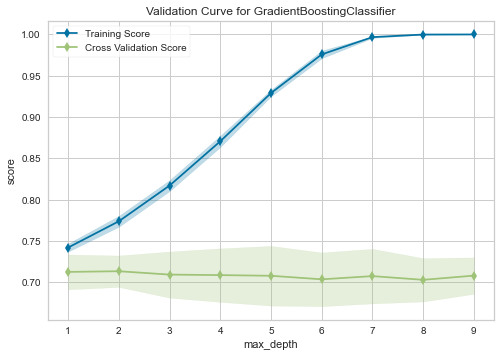

In [77]:
hyperparameter_curve(GradientBoostingClassifier(),"max_depth",np.arange(1, 10),X,y,"accuracy")

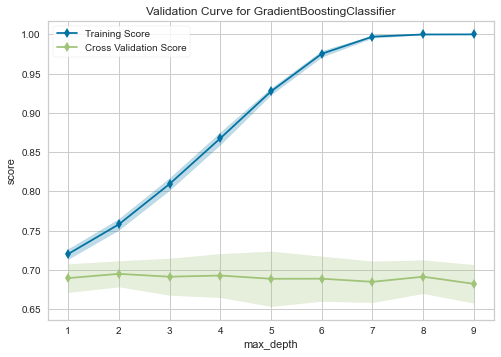

In [79]:
hyperparameter_curve(GradientBoostingClassifier(),"max_depth",np.arange(1, 10),X,y,"f1_weighted")

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


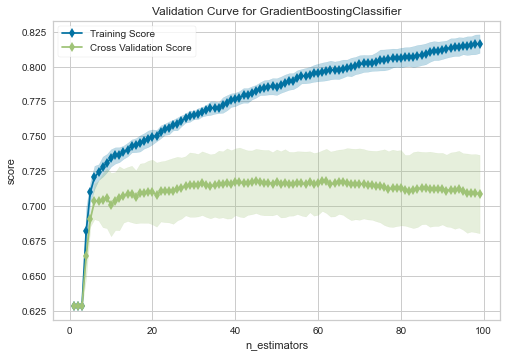

In [80]:
hyperparameter_curve(GradientBoostingClassifier(),"n_estimators",np.arange(1, 100),X,y,"accuracy")

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


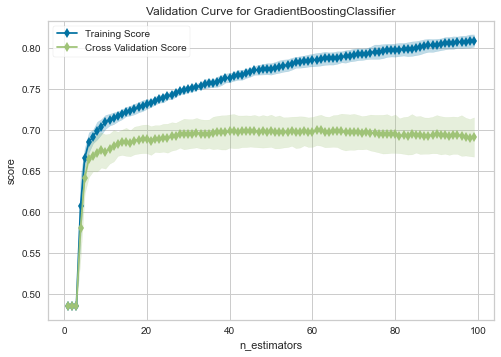

In [81]:
hyperparameter_curve(GradientBoostingClassifier(),"n_estimators",np.arange(1, 100),X,y,"f1_weighted")

In [73]:
select_best_parameters_gbc(X_train,y_train,[i+1 for i in range(6)],[i+40 for i in range(26)])

Per Hyperparameter tuning, best parameters are:
{'max_depth': 6, 'n_estimators': 59}


In [87]:
model = GradientBoostingClassifier(max_depth = 3, n_estimators =  44)

In [82]:
model = GradientBoostingClassifier(max_depth = 6, n_estimators =  59)

In [88]:
generated_confusion_matrix = best_model_gbc(model,X_train,y_train,X_test,y_test)

Train score 0.7736089841755998
Test score 0.7285714285714285
              precision    recall  f1-score   support

        high       0.33      0.03      0.05        35
         low       0.66      0.59      0.62       321
      medium       0.76      0.84      0.80       624

    accuracy                           0.73       980
   macro avg       0.58      0.49      0.49       980
weighted avg       0.71      0.73      0.71       980



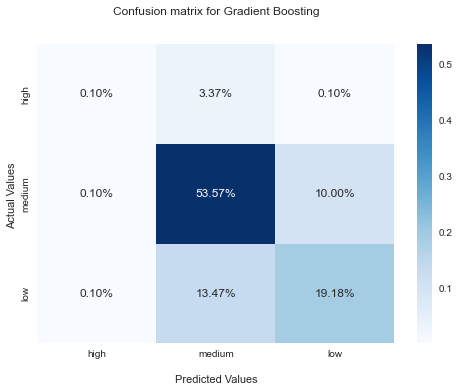

In [89]:
display_confusion_matrix(generated_confusion_matrix,['high','medium','low'],'Confusion matrix for Gradient Boosting')

In [85]:
k_folds(10,model,X,y)

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Average accuracy using k folds: 0.723379658611911


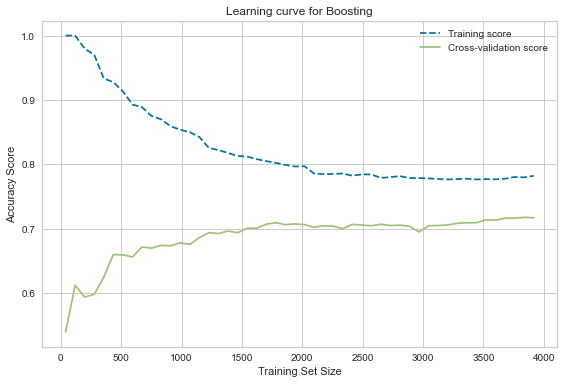

In [90]:
plot_learning_curve(model,X,y,"Learning curve for Boosting")

# Neural Network

In [91]:
#******************DEFINING FUNCTIONS*****************

def run_basic_nn(train_input,
                  train_output,
                  test_input,
                  test_output):

    
    clf = MLPClassifier()

    model = clf.fit(train_input, train_output)
    
    test_predictions = model.predict(test_input)
    train_prediction = model.predict(train_input)

    print(f'Initial Train score {accuracy_score(train_output,train_prediction)}')
    print(f'Initial Test score {accuracy_score(test_output,test_predictions)}')

    print(classification_report(test_output, test_predictions))


def find_best_activation_func(train_input,
                              train_output,
                              test_input,
                              test_output):
    
    activ_func = {}
    activation_funcs= ['identity','logistic','tanh','relu']
    for i in activation_funcs:

        clf = MLPClassifier(activation = i)
        clf.fit(train_input, train_output)
        test_predictions = clf.predict(test_input)
        activ_func[i] = metrics.accuracy_score(test_output, test_predictions)


    activ_func = dict(sorted(activ_func.items(), key=operator.itemgetter(1),reverse=True))
    print(activ_func)

    activ_funcs = list(activ_func.keys())
    accuracy = list(activ_func.values())

    fig = plt.figure(figsize = (5, 3.5))

    plt.bar(activ_funcs,accuracy, color ='red',width = 0.4)

    plt.xlabel("Activation function")
    plt.ylabel("Accuracy")
    plt.title("Activation function VS accuries")
    plt.show()

def find_best_hidden_layers_size(train_input,
                              train_output,
                              test_input,
                              test_output,
                              hidden_layer_sizes_li):
    
    
    hidden_layer_sizes_li = hidden_layer_sizes_li
    
    accuracy_test = []
    accuracy_train = []

    for i in hidden_layer_sizes_li:    
        
        clf = MLPClassifier(hidden_layer_sizes=(i,), activation='logistic', )
        clf.fit(train_input, train_output)
        
        predictions_test = clf.predict(test_input)
        predictions_train = clf.predict(train_input)
        
        accuracy_test.append(accuracy_score(test_output, predictions_test))
        accuracy_train.append(accuracy_score(train_output, predictions_train))
      
    plt.plot(hidden_layer_sizes_li, accuracy_test, 'o-', color='red', label='Test Score')
    plt.plot(hidden_layer_sizes_li, accuracy_train, 'o-', color = 'blue', label='Train Score')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of Hidden Units')
    
    plt.title("Validation curve")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    
def select_best_parameters_nn(train_input, train_output,
                             hidden_layer_sizes,activation):


    param_grid = {'hidden_layer_sizes': hidden_layer_sizes,
                  'activation': activation}

    boost = GridSearchCV(estimator = MLPClassifier(), param_grid=param_grid, cv=10)
    boost.fit(train_input, train_output)
    print("Per Hyperparameter tuning, best parameters are:")
    print(boost.best_params_)

def best_model_nn(train_input,
                   train_output,
                   test_input,
                   test_output,
                   hidden_layer_sizes,
                   activation):
    
    clf = MLPClassifier(hidden_layer_sizes =  hidden_layer_sizes,
                        activation = activation)
    
    clf.fit(train_input, train_output)

    test_predictions = clf.predict(test_input)
    train_predictions = clf.predict(train_input)

    print(f'Train score {accuracy_score(train_output,train_predictions)}')
    print(f'Test score {accuracy_score(test_output,test_predictions)}')

    print(classification_report(test_output, test_predictions))
    return confusion_matrix(test_output,test_predictions,labels=['high','medium','low'])

In [92]:
train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()

columns = [i for i in train_df_scaled.columns if i!='quality_label']

train_df_scaled = use_standard_scaler(columns, train_df_scaled)
test_df_scaled = use_standard_scaler(columns, test_df_scaled)

y_train_scaled = train_df_scaled['quality_label']
X_train_scaled = train_df_scaled.drop('quality_label', 1)

y_test_scaled = test_df_scaled['quality_label']
X_test_scaled = test_df_scaled.drop('quality_label', 1)

y_train.value_counts()

wine_quality_df_nn = wine_quality_df.copy()
wine_quality_df_nn = use_standard_scaler(columns, wine_quality_df_nn)

y = wine_quality_df_nn['quality_label']
X = wine_quality_df_nn.drop('quality_label', 1)


C:\Users\Hp\AppData\Local\Temp\ipykernel_2640\3888815218.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train_scaled = train_df_scaled.drop('quality_label', 1)
C:\Users\Hp\AppData\Local\Temp\ipykernel_2640\3888815218.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test_scaled = test_df_scaled.drop('quality_label', 1)
C:\Users\Hp\AppData\Local\Temp\ipykernel_2640\3888815218.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = wine_quality_df_nn.drop('quality_label', 1)


In [93]:
run_basic_nn(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

Initial Train score 0.8004083716181726
Initial Test score 0.75
              precision    recall  f1-score   support

        high       0.29      0.06      0.10        35
         low       0.69      0.64      0.66       321
      medium       0.78      0.85      0.81       624

    accuracy                           0.75       980
   macro avg       0.59      0.51      0.52       980
weighted avg       0.73      0.75      0.74       980



C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'relu': 0.7448979591836735, 'tanh': 0.7357142857142858, 'logistic': 0.7224489795918367, 'identity': 0.7122448979591837}


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


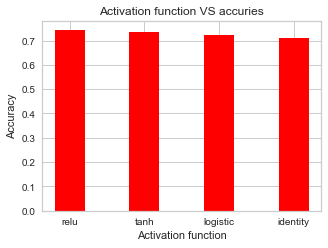

In [94]:
find_best_activation_func(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

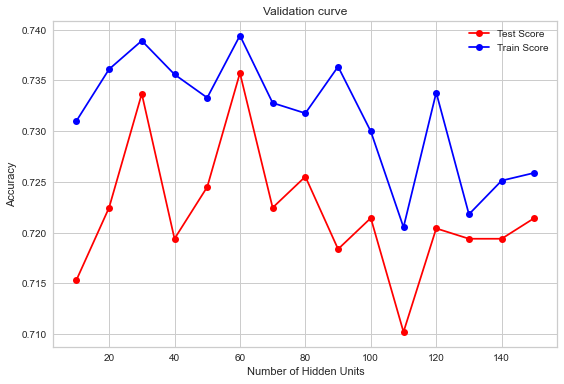

In [95]:
hidden_layer_sizes_li = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

find_best_hidden_layers_size(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled,hidden_layer_sizes_li)

In [172]:
hidden_layer_sizes_li = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
activation = ['relu','tanh']
select_best_parameters_nn(X_train_scaled, y_train_scaled,
                   hidden_layer_sizes_li,
                   activation)

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Per Hyperparameter tuning, best parameters are:
{'activation': 'tanh', 'hidden_layer_sizes': 40}


In [96]:
hidden_layer_sizes = (40,)
activation = 'tanh'
cm_nn = best_model_nn(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled,
                   hidden_layer_sizes,
                   activation)

Train score 0.7649310872894334
Test score 0.7540816326530613
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        35
         low       0.70      0.63      0.66       321
      medium       0.78      0.86      0.82       624

    accuracy                           0.75       980
   macro avg       0.49      0.50      0.49       980
weighted avg       0.72      0.75      0.74       980



C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


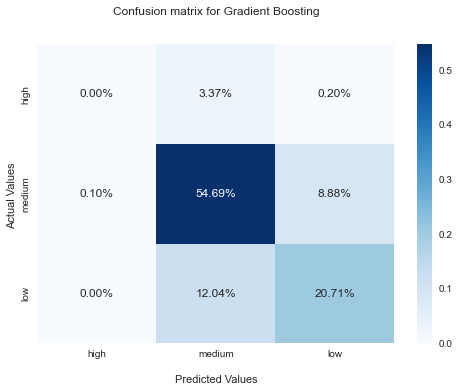

In [97]:
display_confusion_matrix(cm_nn,['high','medium','low'],'Confusion matrix for Gradient Boosting')

In [98]:
model = MLPClassifier(activation = 'tanh', hidden_layer_sizes =  (40,))
k_folds(10,model,X,y)

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optim

Average accuracy using k folds: 0.7235862443136764


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

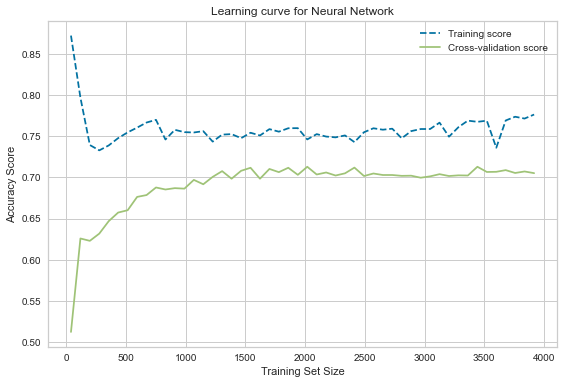

In [99]:
plot_learning_curve(model,X,y,"Learning curve for Neural Network")